<a href="https://colab.research.google.com/github/rakshithcgowda/Machine-learning-project/blob/main/NLP_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install -q transformers
!pip install torch torchvision
!pip list transformers
!pip install transformers
!pip install sklearn
!pip install scikit_learn
!pip install tensorflow-hub
!pip install tensorflow_text
!pip install torch


In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
# # importing the data
df = pd.read_csv('train.csv')
df.head()

,,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# df['keyword'].isnull
# df['location'].isnull

if df['keyword'].isnull().any():
    df = df.dropna(subset=['keyword'])

if df['location'].isnull().any():
    df = df.dropna(subset=['location'])

df.head()

,,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [ ]:
new_df = df[['text','target']]
new_df.head()

,text,target
31,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,We always try to bring the heavy. #metal #RT h...,0
33,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,Crying out for more! Set me ablaze,0
35,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [ ]:
new_df.groupby('target').describe()

text                                                               
       count unique                                                top freq
target                                                                     
0       2884   2873  @TinyJecht Are you another Stand-user? If you ...    3
1       2196   2163  #Bestnaijamade: 16yr old PKK suicide bomber wh...    6

In [ ]:
2196/2884*100

76.14424410540916

In [ ]:
def data (data_file):
  texts = new_df['text'].tolist()
  labels = [1 if sentiment == "positive" else 0 for sentiment in new_df['target'].tolist()]
  return (texts,labels)
datafile = new_df
datafile.head()
datafile.shape

(5080, 2)

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()


,,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Displaying rows and columns in dataset

print("There are {} rows and {} columns in training data".format(train.shape[0],train.shape[1]))
print("There are {} rows and {} columns in training data".format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in training data
There are 3263 rows and 4 columns in training data


# Balancing the data

In [ ]:
# df_0_class = df[df['target'] == 0 ]
# df_1_class = df[df['target'] == 1]

# df_0_class_undersampled = df_0_class.sample(df_1_class.shape[0])
# df = pd.concat([df_0_class_undersampled, df_1_class],axis=0)
# print(df_0_class.shape)
# print(df_1_class.shape)
# print(df.shape)

df_target_0 = df[df['target'] == 0]
df_target_0.shape

(2884, 5)

In [ ]:
df_target_1 = df[df['target'] == 1]
df_target_1.shape

(2196, 5)

In [ ]:
sample_size = df_target_0.shape[0]

# Oversample df_target_1 with replacement
df_target_1_sampled = df_target_1.sample(n=sample_size, replace=True, random_state=42)

df_target_1_sampled.shape

(2884, 5)

In [ ]:
# concating the funtion
df_balance = pd.concat([df_target_0,df_target_1_sampled])
df_balance.shape

(5768, 5)

In [ ]:
# value counting
df_balance['target'].value_counts()

0    2884
1    2884
Name: target, dtype: int64

# **Training the data**


In [ ]:
# from sklearn.model_selection import train_test_split

# X_train,X_test,y_test,y_train = train_test_split(df_balance['text'],df_balance['target'])
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balance['text'], df_balance['target'], test_size=0.2, random_state=42)


In [ ]:
X_test.head()

1739    Motorcyclist bicyclist injured in Denver colli...
2448    Consent Order on cleanup underway at CSX derai...
5792    I think Twitter was invented to keep us insomn...
3209    #Nursing alert: Emergency Department Psychiatr...
5547    Wow what beauty lies within every storm. Taken...
Name: text, dtype: object

# BERT TEXT CLASSIFICATION

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")



In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [ ]:
len(X_train)

4614

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
145/145 [==============================] - 2273s 16s/step - loss: 0.6528 - accuracy: 0.6259 - precision: 0.6190 - recall: 0.6582
Epoch 2/20
 85/145 [================>.............] - ETA: 15:30 - loss: 0.6243 - accuracy: 0.6632 - precision: 0.6615 - recall: 0.6798

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

37/37 [==============================] - 14s 364ms/step


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
threshold = 0.4
y_predicted.shape
df_balance['target'].shape

(5768,)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[462, 119],
       [156, 417]])

Text(50.722222222222214, 0.5, 'Truth')

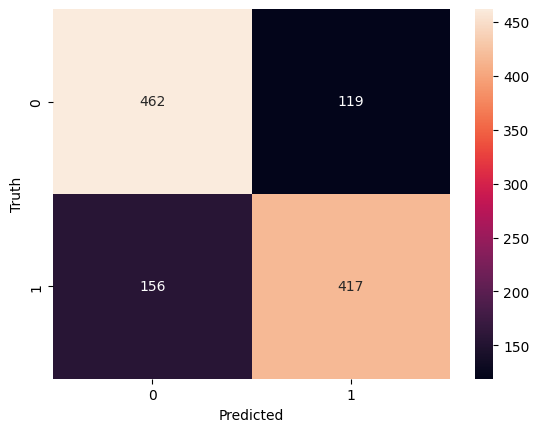

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       581
           1       0.78      0.73      0.75       573

    accuracy                           0.76      1154
   macro avg       0.76      0.76      0.76      1154
weighted avg       0.76      0.76      0.76      1154



In [ ]:
tweet = ['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all']
model.predict(tweet)

1/1 [==============================] - 0s 97ms/step


array([[0.5397297]], dtype=float32)

In [ ]:
sample = pd.read_csv('test.csv')
sample.head()
sample.shape

(3263, 4)

In [ ]:
# y_predicted = model.predict(sample['text'])
# y_predicted = y_predicted.flatten()
# y_predicted = np.where(y_predicted > 0.5, 1, 0)
# Assuming y_predicted is a NumPy array
y_predicted = model.predict(sample['text'])
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

# Convert y_predicted to a pandas DataFrame
y_predicted_df = pd.DataFrame({'Predicted_Label': y_predicted})

# Now, y_predicted_df is a pandas DataFrame with one column 'Predicted_Label'


102/102 [==============================] - 38s 372ms/step


In [ ]:
y_predicted

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
submision = y_predicted_df
submission = df[['id']]
submision.to_csv('submission.csv',index=False)